<a href="https://colab.research.google.com/github/Tirrenus/PUC-RIO_Machine_Learning_and_Analytics-MVP/blob/main/PUC_RIO_Machine_Learning_%26_Analytics_MVP_20250927_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - PUC_RIO - Machine Learning & Analytics
- **Curso Ciência de Dados e Analytics - 27/Set/2025**

  - Aluno:      Fabio Nunes Martins - Matrícula: 4052024002332
  - Professor:  Hugo Villamizar
  - Professor:  Patrick Happ

# 1 - Escopo, objetivo e definição do problema

Este MVP tem por objetivo promover a análise de dados de uma empresa que presta serviço de Suporte em TI.

Com o apoio da **Machine Learnin**g com aprendizado **SUPERVISIONADO** e tratando com um problema de **CLASSIFICAÇÃO** , esta análise visa apoiar decisões da empresa em futuras renovações de contratos que sejam baseados em SLA( Service Level Agreement), e nas possíveis readequações de suas equipes.

Foram analisados os dados referentes aos tickets de Incidentes abertos entre  Fevereiro de 2016 a Fevereiro de 2017. As informações sensíveis foram anonimizadas para fins de privacidade.


## Hipóteses do Problema

Considerando que os ticket são atendidos pelos escritórios localizados no Brasil e na índia, sendo que o maior número de chamados sào atendidos atendidos pelos escritório da India, presumimos que:


  *   O escritório localizado na India tem mais tickets de incidentes com o prazo de atendimento com SLA NÃO Cumpridos;
  *   Que os tickets de incidentes classificados como CRÍTICO foram os que mais tiveram o SLA violado devido ao curtos tempos de resolução acordados em contrato;
  *   O Escritório do Brasil tem um percentual de violacão de SLA mais baixo, considerando todas a prioridades (Critico, Alto, Moderado e Baixo),se comparado aos percentuais do escritório localizado na India.








##Tipo de Problema

Tipo de Tarefa:  **classificação, supervisionada**. Dado um conjunto de características (Prioridade do Ticket de inciente (SLA), Escritório que atende o Ticket, Indicação se o ticket foi resolvido dento do SLA ou não), o objetivo é prever o cumprimento do SLA acordado em contrato.

##Seleção de Dados

Origem dos dados:
- incident_event_log.csv - Kraggle - https://www.kaggle.com/datasets/shamiulislamshifat/it-incident-log-dataset



O arquivo **incident_event_log.csv** foi baixado manualmente do site https://www.kaggle.com/datasets/shamiulislamshifat/it-incident-log-dataset . Esse dataset foi ecolhido porque **não contém dados sensíveis** que identifiquem empresas ou pessoas reais. As informações sensíveis foram anonimizadas para fins de privacidade.

# 2 - Reprodutibilidade e ambiente

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import requests
import zipfile
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer


from scipy.stats import randint, uniform

# Definir seed global
seed = 42
np.random.seed(seed)


##from sklearn.preprocessing import LabelEncoder
##from sklearn.naive_bayes import MultinomialNB
##from sklearn.model_selection import RandomizedSearchCV
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.model_selection import train_test_split
###from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score



# 3 - Dados: carga, entendimento e qualidade

In [ ]:
# Extração dos dados do dataset
url = 'https://raw.githubusercontent.com/Tirrenus/PUC-RIO_Machine_Learning_and_Analytics-MVP/main/dataset/incident_event_log.zip'
filename = 'incident_event_log.csv'
request = requests.get(url)
zipFile = zipfile.ZipFile(io.BytesIO(request.content))
zipFile.extractall()

# Carga no dataframe
df = pd.read_csv(filename, sep=',')

# Ignore wirnings
warnings.filterwarnings('ignore')  # Ignora todos os warnings


## Limpeza e Preparação dos dados


Remoção das linhas onde :


*   o status do Incidente são diferentes de "Closed" - Evitamos assim a redundância de Atributos uma vez que a linha com o status "Closed" contém todos os dados relevantes a nossa análise;
*   os campos da Coluna "resolved_by" são iguais a "?" - Remoção linhas devido a falta de dados relevantes a nossa análise;
*   os campos da Coluna "location" são iguais a "?"  - Remoção linhas devido a falta de dados relevantes a nossa análise.
*   os campos "incident_state" são iguais a "-100"





Tratamento dos dados.

*   Conversão dos campos 'opened_at', 'resolved_at', 'closed_at' do tipo STRING para DATETIME para um possível cálculo de duração caso seja necessário a validacão de cumprimrnto do SLA.
*   Remoção de colunas que não são relevantes a nossa análise;
*   Renomeação dos campos da Coluna Location com a descrição do Pais de acordo com seus respectivoc códigos;
*   Adição das colunas 'tempo_para_resolver' e 'tempo_para_fechar' que contém os tempos de duração de resolução e de fechamento de cada ticket.



In [ ]:
# Início das transformções dos dados e carga ( Dados já sob tratamento)

# Remover das linhas onde :
    #   Status do Incidente são diferentes de "Closed"
    #   os campos da Coluna "resolved_by" são iguais a "?"
    #   os campos da Coluna "location" são iguais a "?"
    #   os campos da Coluna "incident_state" são iguais a "-100"
df=df.loc[(df['incident_state']=="Closed") &
 (df['resolved_at']!="?") &
  (df['resolved_by']!="?") &
   (df['location']!="?") &
    (df['incident_state'] != "-100")]



# Substituição dos campos com valor "?" por "NaN"
df.replace("?", pd.NA, inplace=True)



# Converter datas - String para Datatime
date_cols = ['opened_at', 'resolved_at', 'closed_at', 'sys_created_at', 'sys_updated_at']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)



# Criar colunas de tempo de resolução e tempo até fechamento (em horas)
pd.options.mode.copy_on_write = True
df['tempo_para_resolver'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds() / 3600
df['tempo_para_fechar'] = (df['closed_at'] - df['opened_at']).dt.total_seconds() / 3600


# Preenchendo com os dados da coluna "location" com os seus respectivos Países on foram tratados.
df.loc[df['location'].str.startswith('Location 1') , 'location'] = 'India'
df.loc[df['location'].str.startswith('Location 2') , 'location'] = 'Brazil'
df.loc[df['location'].str.startswith('Location 3') , 'location'] = 'Brazil'
df.loc[df['location'].str.startswith('Location 4') , 'location'] = 'Brazil'
df.loc[df['location'].str.startswith('Location 5') , 'location'] = 'India'
df.loc[df['location'].str.startswith('Location 6') , 'location'] = 'Brazil'
df.loc[df['location'].str.startswith('Location 7') , 'location'] = 'Brazil'
df.loc[df['location'].str.startswith('Location 8') , 'location'] = 'Brazil'
df.loc[df['location'].str.startswith('Location 9') , 'location'] = 'Brazil'


# primeiras linhas
df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,tempo_para_resolver,tempo_para_fechar
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,<NA>,<NA>,<NA>,<NA>,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,10.216667,130.733333
12,INC0000047,Closed,False,1,0,8,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,...,<NA>,<NA>,<NA>,<NA>,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,29.200000,149.333333
19,INC0000057,Closed,False,0,0,6,True,Caller 4416,Opened by 8,2016-02-29 06:10:00,...,Problem ID 2,<NA>,<NA>,<NA>,code 10,Resolved by 5,2016-03-01 02:55:00,2016-03-06 03:00:00,20.750000,140.833333
23,INC0000060,Closed,False,0,0,3,True,Caller 4491,Opened by 180,2016-02-29 06:38:00,...,<NA>,<NA>,<NA>,<NA>,code 3,Resolved by 113,2016-03-02 12:06:00,2016-03-07 13:00:00,53.466667,174.366667
31,INC0000062,Closed,False,1,0,7,False,Caller 3765,Opened by 180,2016-02-29 06:58:00,...,<NA>,<NA>,<NA>,<NA>,code 7,Resolved by 62,2016-02-29 15:51:00,2016-03-05 16:00:00,8.883333,129.033333


## 3.1 Análise exploratória resumida (EDA)

Nesta etapa de Análise de Dados Exploratória (EDA) sobre o dataset De ticket de incidentes

### Catálogo de dados

**incident_location_log.csv**

![](https://raw.githubusercontent.com/Tirrenus/PUC-RIO_Machine_Learning_and_Analytics-MVP/main/img/metadados_incidentes.png)


### Total e Tipo das Instâncias

O dataset Incidentes possui 23395 instâncias.

In [ ]:
print(f"Total de instâncias: {len(df)}")
print("\nTipos de dados por coluna:")
print(df.info())

Total de instâncias: 23395

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
Index: 23395 entries, 3 to 141711
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   number                   23395 non-null  object        
 1   incident_state           23395 non-null  object        
 2   active                   23395 non-null  bool          
 3   reassignment_count       23395 non-null  int64         
 4   reopen_count             23395 non-null  int64         
 5   sys_mod_count            23395 non-null  int64         
 6   made_sla                 23395 non-null  bool          
 7   caller_id                23392 non-null  object        
 8   opened_by                22759 non-null  object        
 9   opened_at                23395 non-null  datetime64[ns]
 10  sys_created_by           13436 non-null  object        
 11  sys_created_at           13436 non-null  d

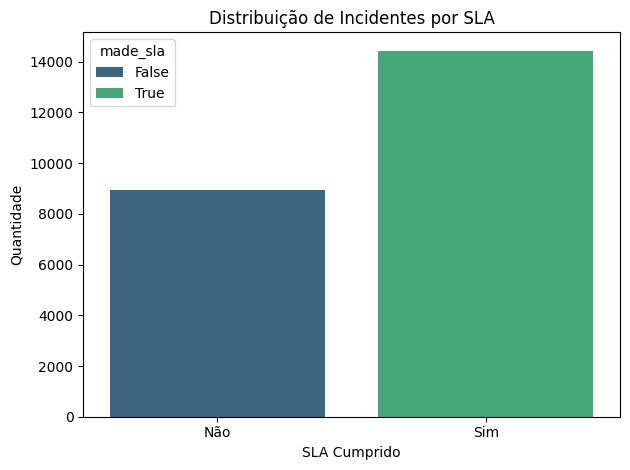

In [ ]:
# SLA Cumprido vs. Não Cumprido
plt.figure()
sns.countplot(data=df, x='made_sla', palette="viridis", hue='made_sla')
#sns.countplot(data=df, x='made_sla', palette="viridis", hue='made_sla')
plt.title("Distribuição de Incidentes por SLA")
plt.xlabel("SLA Cumprido")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ['Não', 'Sim'])
plt.tight_layout()
plt.show()

O gráfico acima mostra que há um número signifacativo e muito superior do que se esperava, de tickets que não cumpriram o SLA.

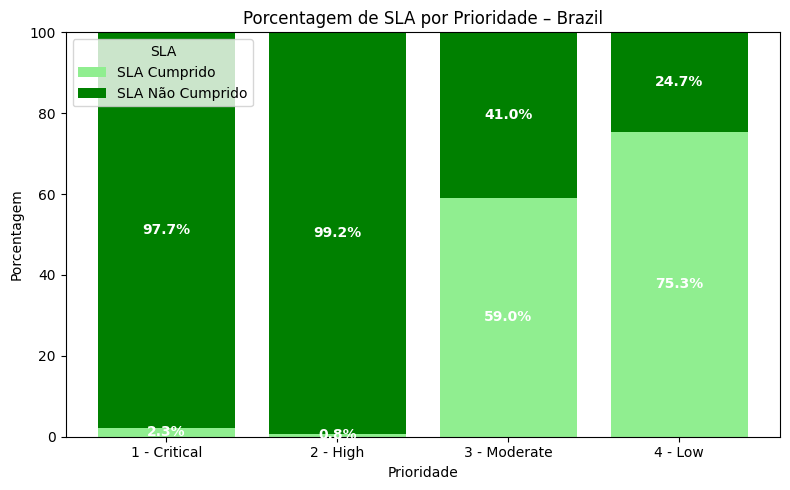

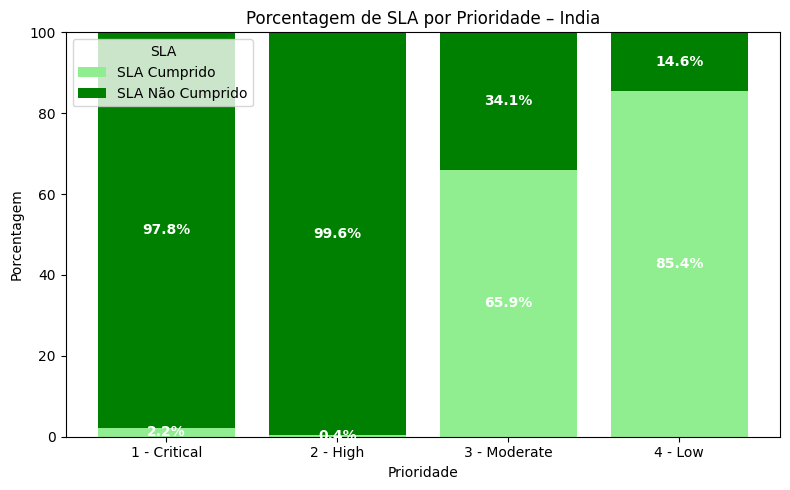

In [ ]:
# Selecionar Top 5 locais ( no nosso caso, há somente dois locations)
top_locations = df['location'].value_counts().head(5).index
df_top = df[df['location'].isin(top_locations)]

# Criar tabela de contagem cruzada
tabela = pd.crosstab([df_top['location'], df_top['priority']], df_top['made_sla'])

# Garantir que colunas True e False existam
for val in [True, False]:
    if val not in tabela.columns:
        tabela[val] = 0

# Calcular porcentagens
tabela_pct = tabela.div(tabela.sum(axis=1), axis=0) * 100
tabela_pct = tabela_pct.reset_index()

# Plotar
# Gráfico para cada localização
locais = tabela_pct['location'].unique()

for local in locais:
    df_loc = tabela_pct[tabela_pct['location'] == local].sort_values('priority')

    plt.figure(figsize=(8, 5))
    plt.bar(df_loc['priority'], df_loc[True], label='SLA Cumprido', color='lightgreen')
    plt.bar(df_loc['priority'], df_loc[False], bottom=df_loc[True], label='SLA Não Cumprido', color='green')

    # Adicionar texto nas barras
    for idx, row in df_loc.iterrows():
        plt.text(row['priority'], row[True] / 2, f"{row[True]:.1f}%", ha='center', va='center', color='white', fontweight='bold')
        plt.text(row['priority'], row[True] + row[False] / 2, f"{row[False]:.1f}%", ha='center', va='center', color='white', fontweight='bold')

    plt.title(f'Porcentagem de SLA por Prioridade – {local}')
    plt.ylabel('Porcentagem')
    plt.xlabel('Prioridade')
    plt.ylim(0, 100)
    plt.legend(title='SLA')
    plt.tight_layout()
    plt.show()

Inicialmente era esperado que o maior número de tickets com SLA não cumpridos fossem em tíckets Criticos atendidos no escritorio da India, porém podemos ver pelo gráfico acima que a maior incidencia foi nos ticket Críticos e Médios tanto no escritório da India como no Brasil.

### Estatísticas Descritivas - Gráficos de Dispersão, Histogramas, Boxplot e Heatmap

Estatísticas descritivas fornecem um resumo das características numéricas, incluindo média, desvio padrão, mínimo, máximo e quartis.

In [ ]:
# estatísticas descritivas básicas do dataset
df.describe()

,reassignment_count,reopen_count,sys_mod_count,opened_at,sys_created_at,sys_updated_at,resolved_at,closed_at,tempo_para_resolver,tempo_para_fechar
count,23395.000000,23395.000000,23395.000000,23395,13436,23395,23395,23395,23395.000000,23395.000000
mean,1.005129,0.014191,7.078222,2016-04-16 00:51:18.811712256,2016-04-10 09:09:06.024114176,2016-04-29 14:39:31.198973696,2016-04-23 11:53:03.475101696,2016-04-29 15:57:58.886941440,179.029073,327.111132
min,0.000000,0.000000,1.000000,2016-02-29 01:16:00,2016-02-29 01:23:00,2016-02-29 17:47:00,2016-02-29 09:04:00,2016-02-29 17:47:00,0.000000,0.033333
25%,0.000000,0.000000,2.000000,2016-03-21 12:45:30,2016-03-16 09:40:00,2016-04-03 09:59:00,2016-03-28 23:42:00,2016-04-03 09:59:00,0.416667,121.083333
50%,0.000000,0.000000,4.000000,2016-04-13 09:28:00,2016-04-05 09:40:30,2016-04-23 20:07:00,2016-04-18 14:53:00,2016-04-24 00:07:00,22.333333,150.466667
75%,1.000000,0.000000,8.000000,2016-05-06 08:51:00,2016-05-01 10:49:15,2016-05-17 10:08:30,2016-05-11 19:07:30,2016-05-17 11:07:00,149.333333,336.650000
max,27.000000,8.000000,129.000000,2017-02-16 14:17:00,2017-01-27 16:59:00,2017-02-18 15:00:00,2017-02-17 00:47:00,2017-02-18 15:00:00,8070.166667,8190.616667
std,1.606861,0.153788,8.701992,NaN,NaN,NaN,NaN,NaN,534.117324,551.832796


### Média

A média é uma medida de tendência central que representa o valor típico ou o ponto de equilíbrio de um conjunto de dados. É calculada somando-se todos os valores e dividindo-se pelo número total de observações. É sensível a valores extremos (outliers).

In [ ]:
# média dos atributos numéricos do dataset
df.describe().loc['mean']

,mean
reassignment_count,1.005129
reopen_count,0.014191
sys_mod_count,7.078222
opened_at,2016-04-16 00:51:18.811712256
sys_created_at,2016-04-10 09:09:06.024114176
sys_updated_at,2016-04-29 14:39:31.198973696
resolved_at,2016-04-23 11:53:03.475101696
closed_at,2016-04-29 15:57:58.886941440
tempo_para_resolver,179.029073
tempo_para_fechar,327.111132


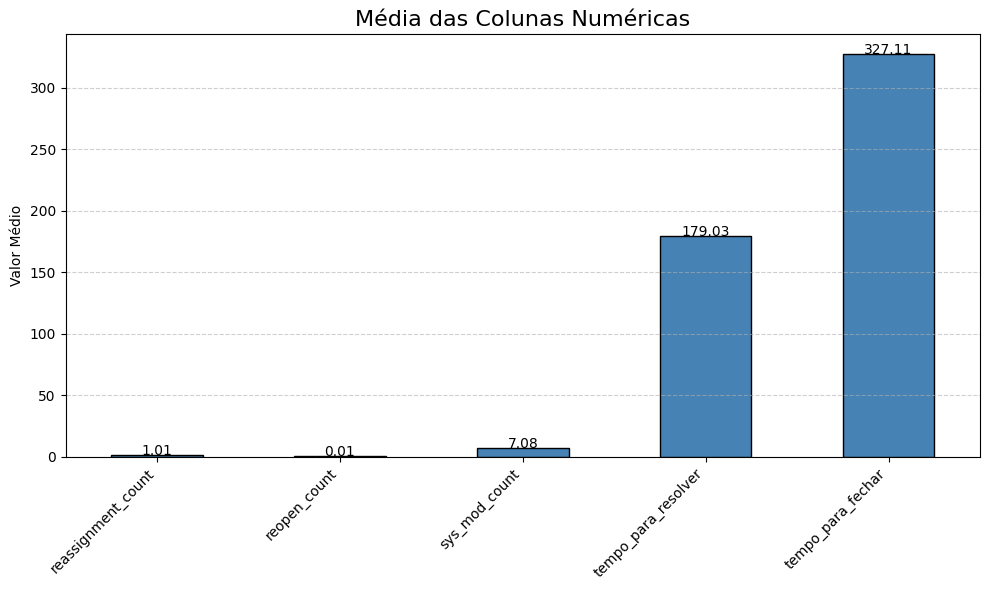

In [ ]:
numeric_data = df.select_dtypes(include='number')

# Calcular as médias usando describe()
means = numeric_data.describe().loc['mean']

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
means.plot(kind='bar', color='steelblue', edgecolor='black')

plt.title('Média das Colunas Numéricas', fontsize=16)
plt.ylabel('Valor Médio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionar os valores acima das barras
for i, v in enumerate(means):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

O gráfico de barras acima demonstra as médias numéricas.

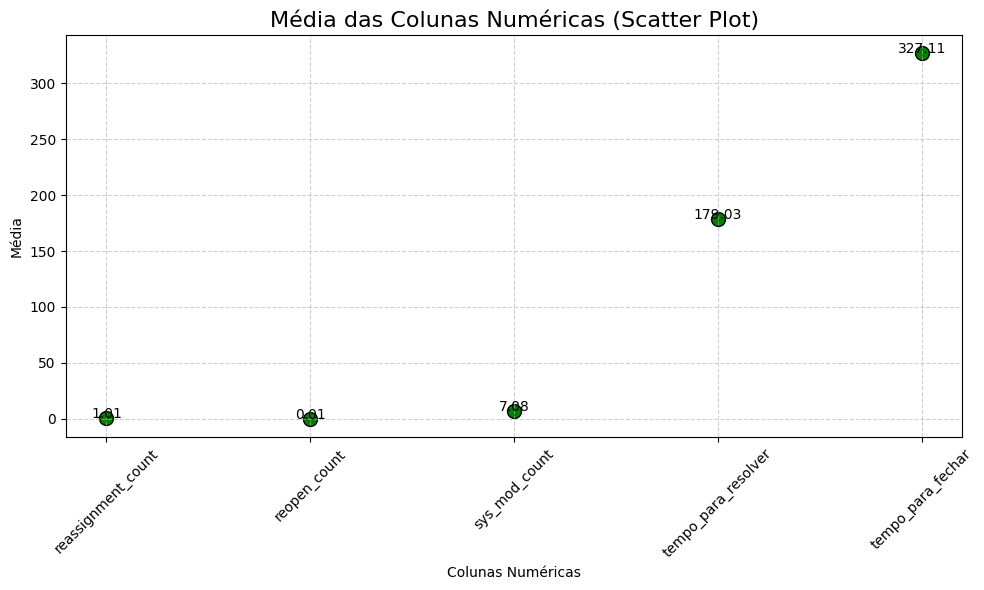

In [ ]:
# Calcular a média
means = numeric_data.describe().loc['mean']

# Preparar os dados para o scatter plot
x = list(means.index)
y = list(means.values)

# Plotar gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='green', s=100, edgecolors='black')

plt.title('Média das Colunas Numéricas (Scatter Plot)', fontsize=16)
plt.xlabel('Colunas Numéricas')
plt.ylabel('Média')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar os valores numéricos
for i in range(len(x)):
    plt.text(x[i], y[i] + 0.02, f'{y[i]:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

O gráfico de dispersão acima demonstra as médias numéricas.

### Desvio Padrão

O desvio padrão é uma medida de dispersão que quantifica a quantidade de variação ou dispersão de um conjunto de valores. Um desvio padrão baixo indica que os pontos de dados tendem a estar próximos da média do conjunto, enquanto um desvio padrão alto indica que os pontos de dados estão espalhados por uma faixa maior de valores. Ele é a raiz quadrada da variância.

In [ ]:
# desvio padrão dos atributos numéricos do dataset
df.describe().loc['std']

,std
reassignment_count,1.606861
reopen_count,0.153788
sys_mod_count,8.701992
opened_at,NaN
sys_created_at,NaN
sys_updated_at,NaN
resolved_at,NaN
closed_at,NaN
tempo_para_resolver,534.117324
tempo_para_fechar,551.832796


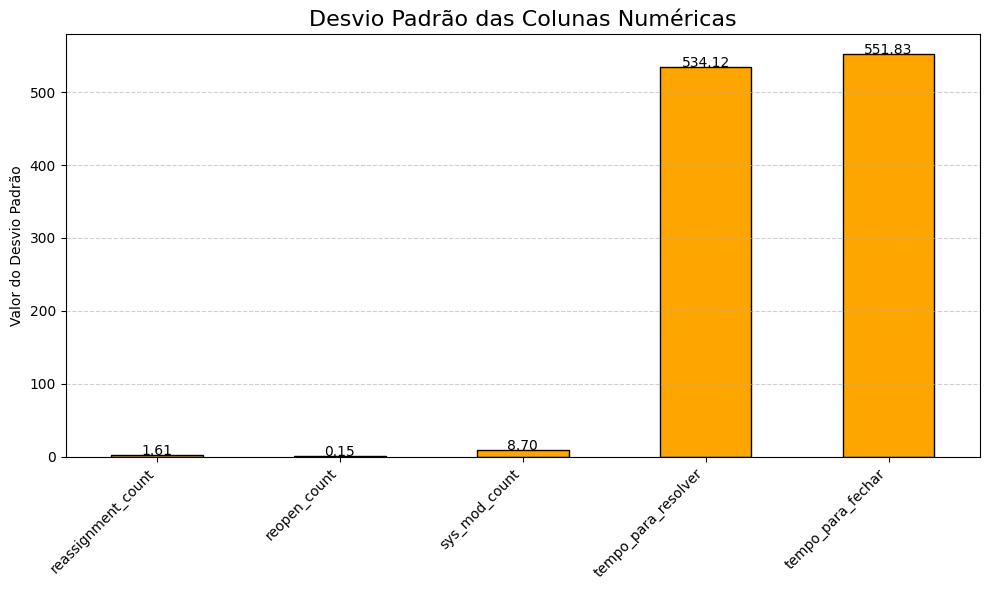

In [ ]:
# Selecionar colunas numéricas
numeric_data = df.select_dtypes(include='number')

# Calcular o desvio padrão com describe()
std_values = numeric_data.describe().loc['std']

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
std_values.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Desvio Padrão das Colunas Numéricas', fontsize=16)
plt.ylabel('Valor do Desvio Padrão')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionar os valores acima das barras
for i, v in enumerate(std_values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

O gráfico de barras acima demonstra o desvio padrão.

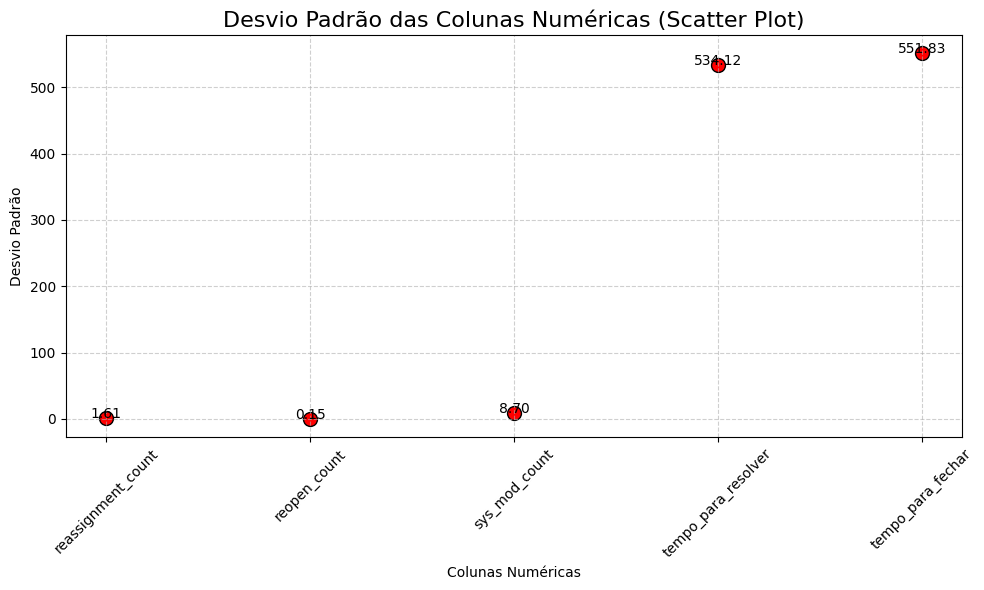

In [ ]:
# Selecionar colunas numéricas
numeric_data = df.select_dtypes(include='number')

# Calcular o desvio padrão
std_values = numeric_data.describe().loc['std']

# Preparar os dados para o scatter plot
x = list(std_values.index)
y = list(std_values.values)

# Plotar gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='red', s=100, edgecolors='black')

plt.title('Desvio Padrão das Colunas Numéricas (Scatter Plot)', fontsize=16)
plt.xlabel('Colunas Numéricas')
plt.ylabel('Desvio Padrão')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar os valores numéricos acima de cada ponto
for i in range(len(x)):
    plt.text(x[i], y[i] + 0.02, f'{y[i]:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

O gráfico de dispersão acima demonstra o desvio padrão.

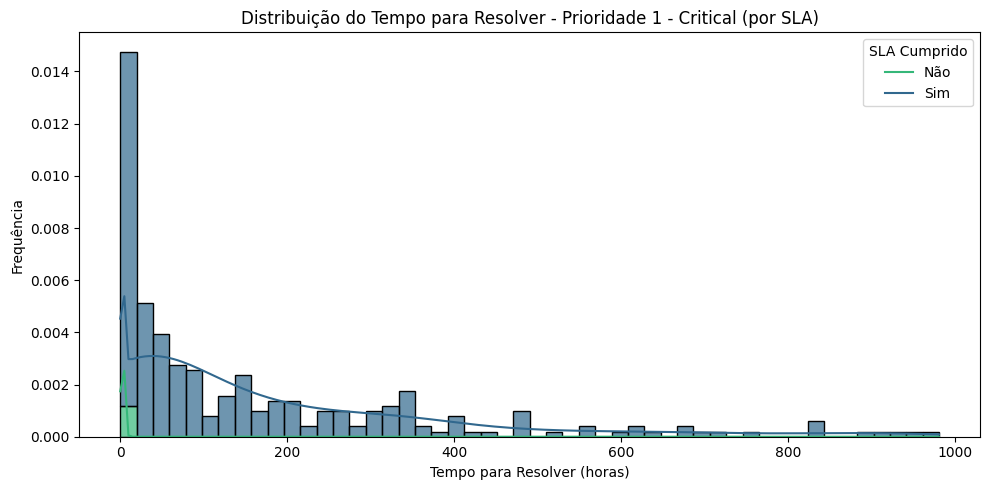

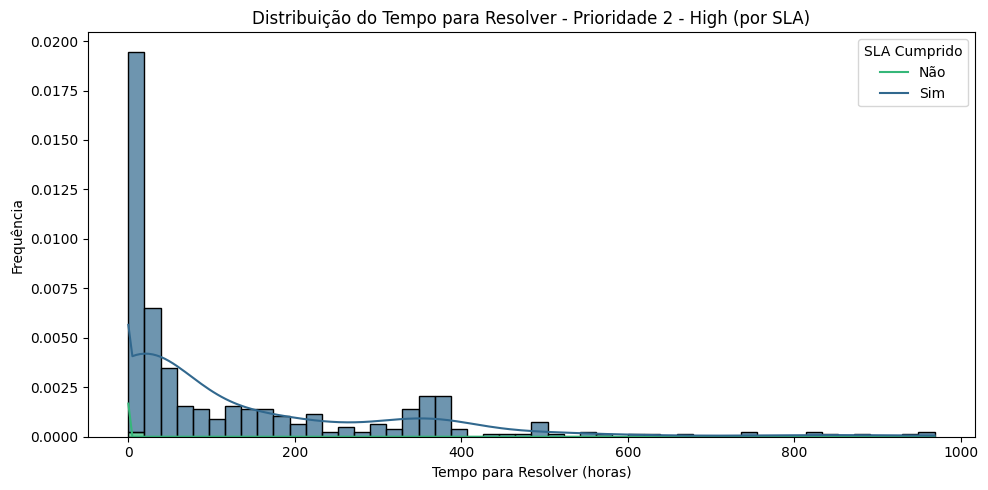

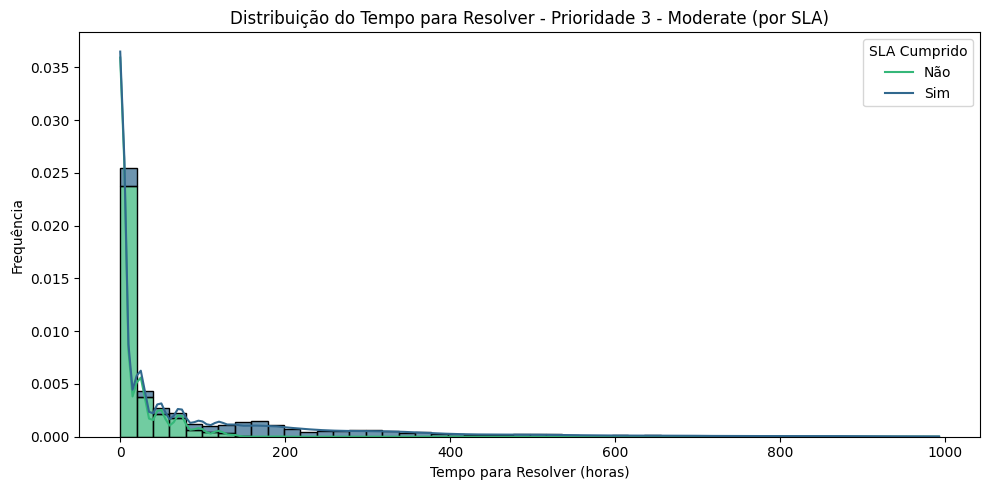

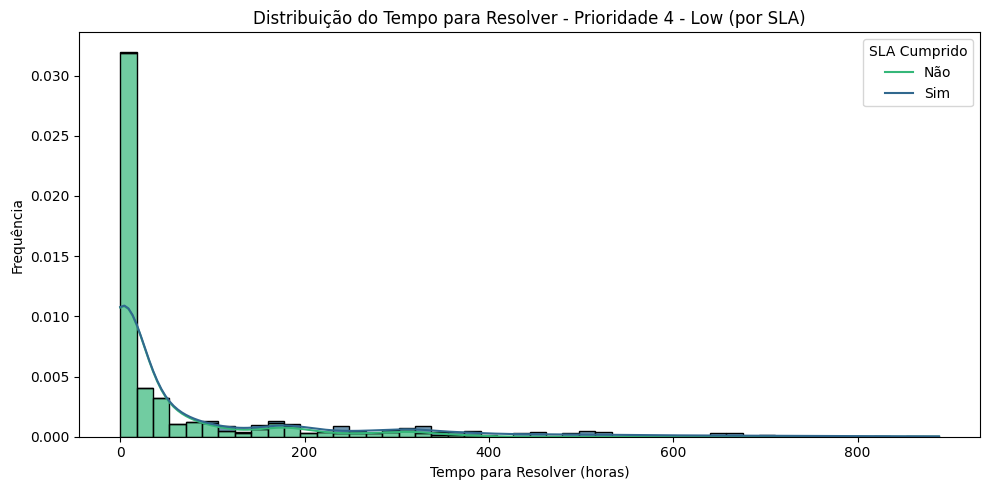

In [ ]:
# Remover outliers extremos
df = df[df['tempo_para_resolver'] < 1000]

# Filtrar Top 3 localizações com mais incidentes
top_locations = df['location'].value_counts().head(3).index
df = df[df['location'].isin(top_locations)]

# Obter valores únicos de prioridade ordenados
prioridades = sorted(df['priority'].dropna().unique())

# Criar 1 gráfico por prioridade
for prio in prioridades:
    df_prio = df[df['priority'] == prio]

    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df_prio,
        x='tempo_para_resolver',
        hue='made_sla',
        multiple='stack',
        bins=50,
        palette='viridis',
        kde=True,
        stat='density',
        alpha=0.7
    )
    plt.title(f'Distribuição do Tempo para Resolver - Prioridade {prio} (por SLA)')
    plt.xlabel('Tempo para Resolver (horas)')
    plt.ylabel('Frequência')
    plt.legend(title='SLA Cumprido', labels=['Não', 'Sim'])
    plt.tight_layout()
    plt.show()

Acima podemos ver histogramas com a distribuição de tickets ( prioridade x tempo de resolucão )

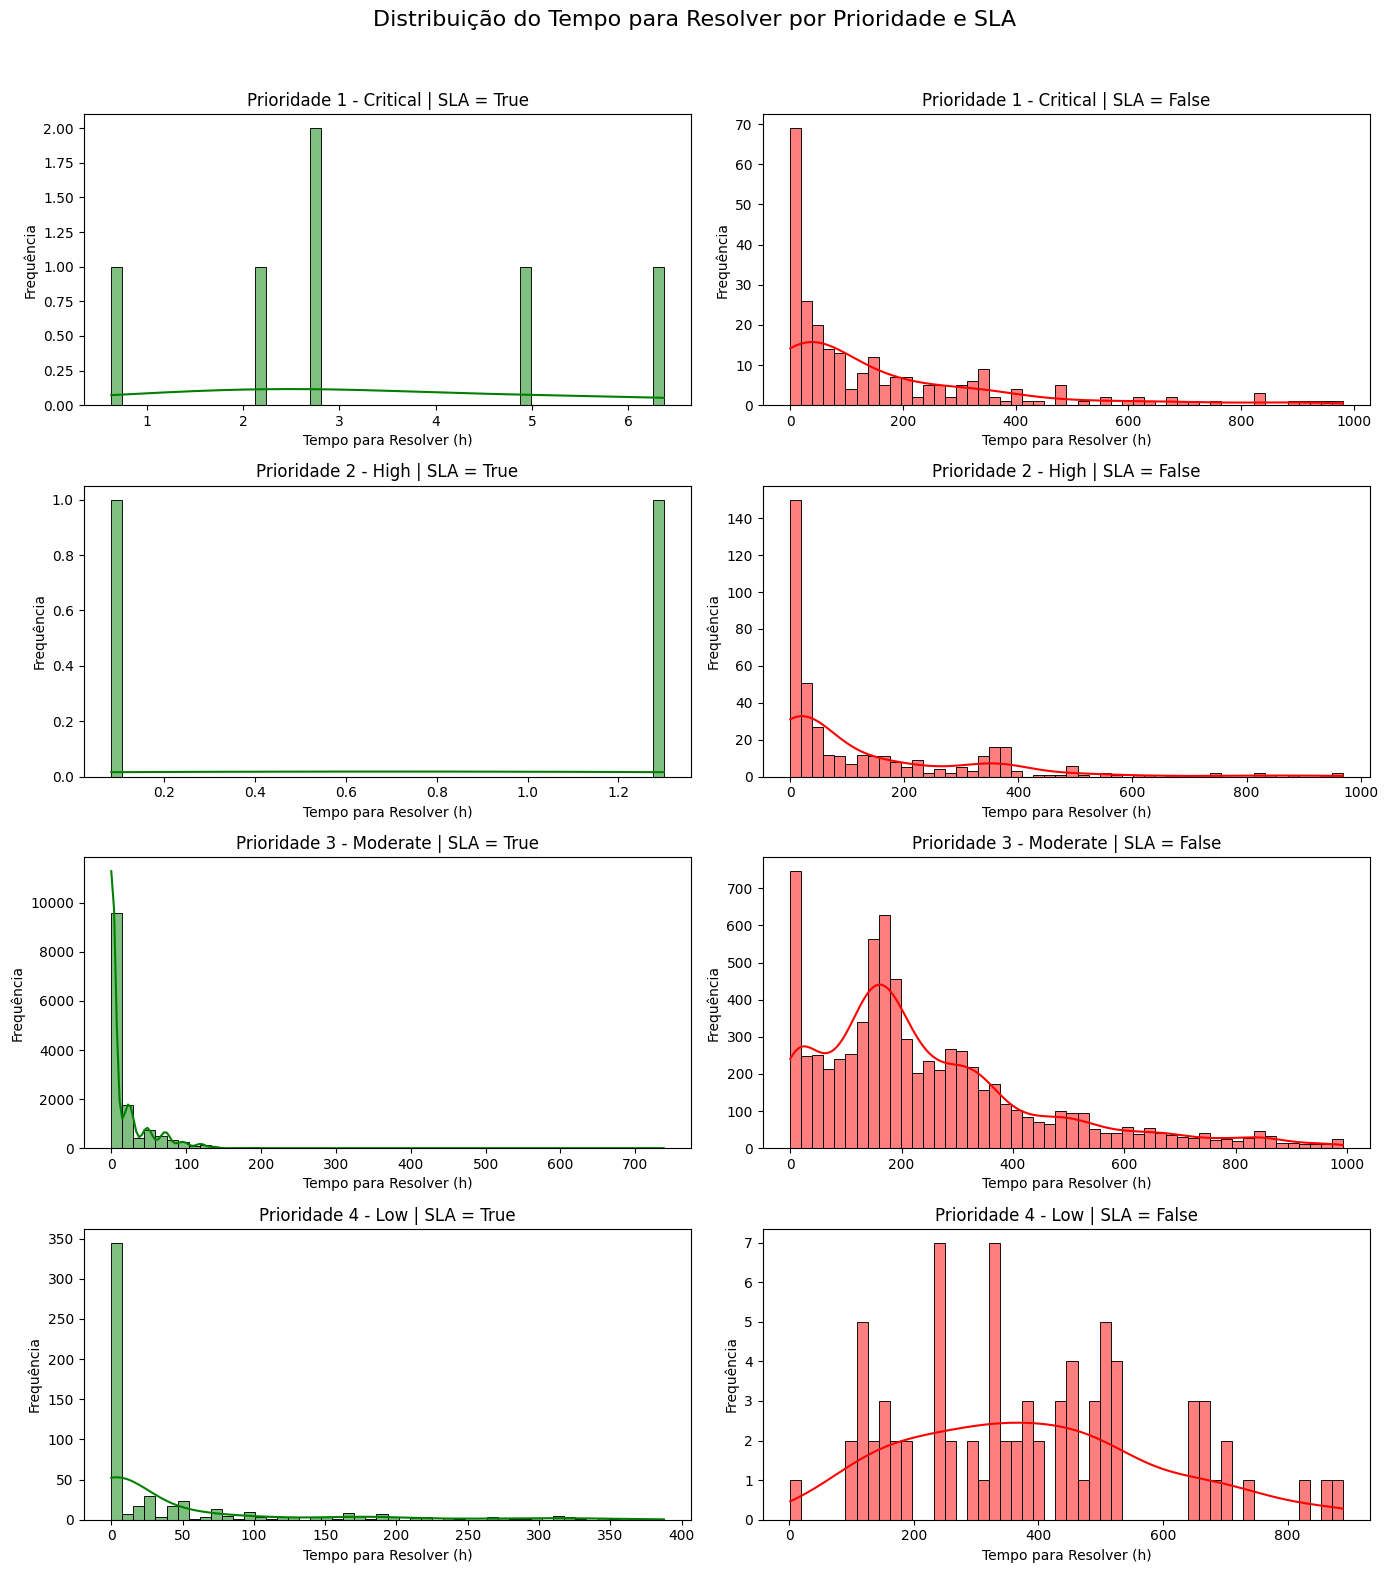

In [ ]:
# Remover outliers extremos
df = df[df['tempo_para_resolver'] < 1000]

# Obter prioridades únicas ordenadas
prioridades = sorted(df['priority'].dropna().unique())

# Criar subplots 4x2 (4 prioridades × 2 SLAs)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
fig.suptitle("Distribuição do Tempo para Resolver por Prioridade e SLA", fontsize=16)

for i, prio in enumerate(prioridades):
    # SLA = True
    df_true = df[(df['priority'] == prio) & (df['made_sla'] == True)]
    sns.histplot(df_true['tempo_para_resolver'], bins=50, kde=True, ax=axes[i, 0], color='green')
    axes[i, 0].set_title(f"Prioridade {prio} | SLA = True")
    axes[i, 0].set_xlabel("Tempo para Resolver (h)")
    axes[i, 0].set_ylabel("Frequência")

    # SLA = False
    df_false = df[(df['priority'] == prio) & (df['made_sla'] == False)]
    sns.histplot(df_false['tempo_para_resolver'], bins=50, kde=True, ax=axes[i, 1], color='red')
    axes[i, 1].set_title(f"Prioridade {prio} | SLA = False")
    axes[i, 1].set_xlabel("Tempo para Resolver (h)")
    axes[i, 1].set_ylabel("Frequência")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Acima podemos ver histogramas com a distribuição de tickets ( prioridade x tempo de resolucão x Cumprimento de SLA )

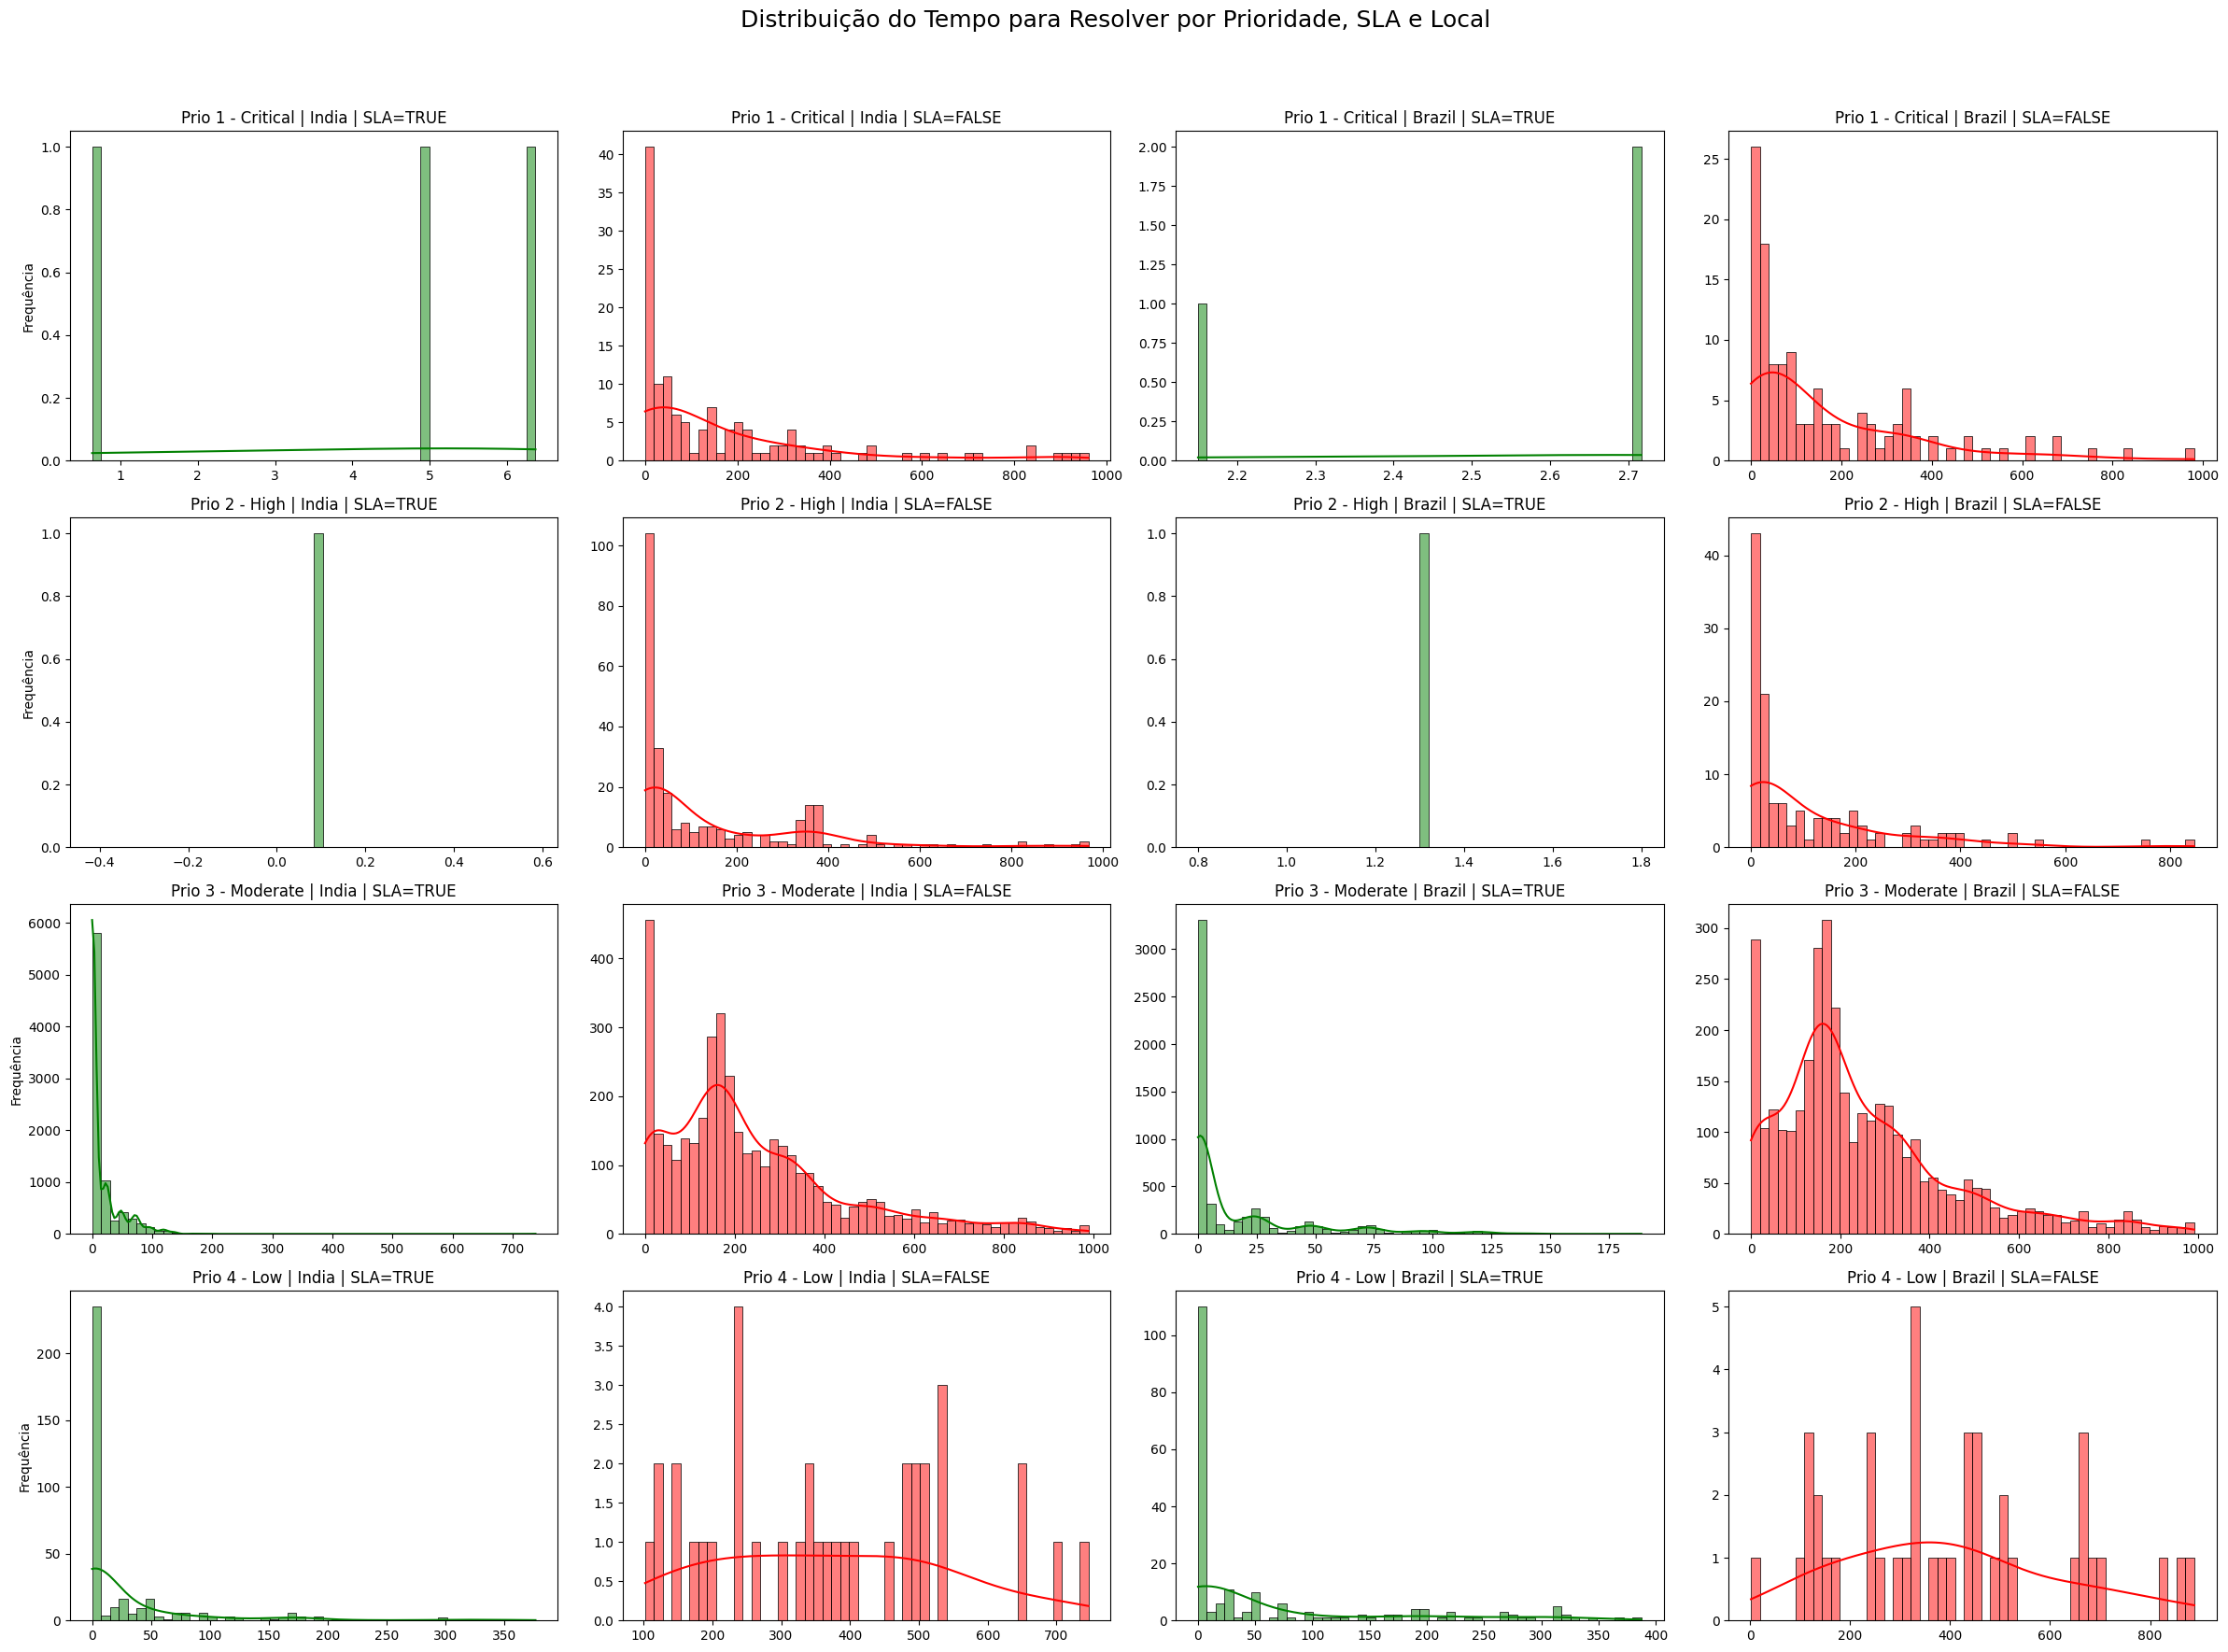

In [ ]:
# Remover outliers extremos
df = df[df['tempo_para_resolver'] < 1000]

# Selecionar top 3 localizações com mais dados
top_locations = df['location'].value_counts().head(3).index
df = df[df['location'].isin(top_locations)]

# Obter prioridades ordenadas
prioridades = sorted(df['priority'].dropna().unique())

# Criar grid de subplots: 4 prioridades x 6 gráficos (3 locais × 2 SLAs)
fig, axes = plt.subplots(nrows=len(prioridades), ncols=4, figsize=(24, 18))
fig.suptitle("Distribuição do Tempo para Resolver por Prioridade, SLA e Local", fontsize=18)

for i, prio in enumerate(prioridades):
    for j, loc in enumerate(top_locations):
        # SLA = True
        df_true = df[(df['priority'] == prio) & (df['location'] == loc) & (df['made_sla'] == True)]
        ax_true = axes[i, j*2]
        sns.histplot(df_true['tempo_para_resolver'], bins=50, kde=True, ax=ax_true, color='green')
        ax_true.set_title(f'Prio {prio} | {loc} | SLA=TRUE')
        ax_true.set_xlabel('')
        ax_true.set_ylabel('Frequência' if j == 0 else '')

        # SLA = False
        df_false = df[(df['priority'] == prio) & (df['location'] == loc) & (df['made_sla'] == False)]
        ax_false = axes[i, j*2+1]
        sns.histplot(df_false['tempo_para_resolver'], bins=50, kde=True, ax=ax_false, color='red')
        ax_false.set_title(f'Prio {prio} | {loc} | SLA=FALSE')
        ax_false.set_xlabel('')
        ax_false.set_ylabel('')

# Ajustar espaçamento
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Acima podemos ver histogramas com a distribuição de tickets ( prioridade x tempo de resolucão x cumprimrnto de SLA x Pais)

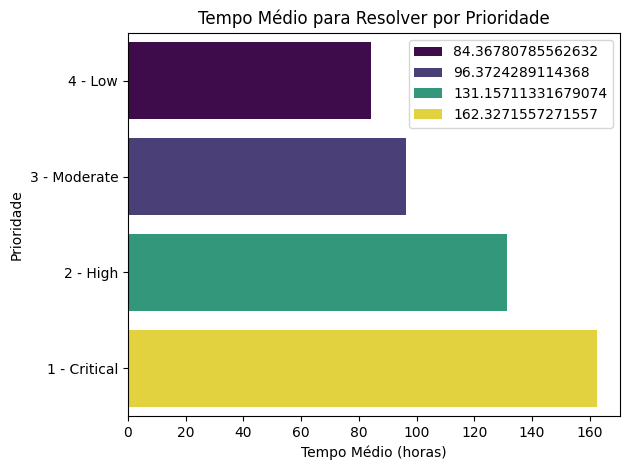

In [ ]:
# Tempo Médio para Resolver por Prioridade
tempo_prio = df.groupby("priority")["tempo_para_resolver"].mean().sort_values()
plt.figure()
sns.barplot(x=tempo_prio.values, y=tempo_prio.index, palette="viridis", hue=tempo_prio.values)
plt.title("Tempo Médio para Resolver por Prioridade")
plt.xlabel("Tempo Médio (horas)")
plt.ylabel("Prioridade")
plt.tight_layout()
plt.show()


No gráfico acima podemos ver a média de tempo de resolução de tickets com relação a cada prioridade.

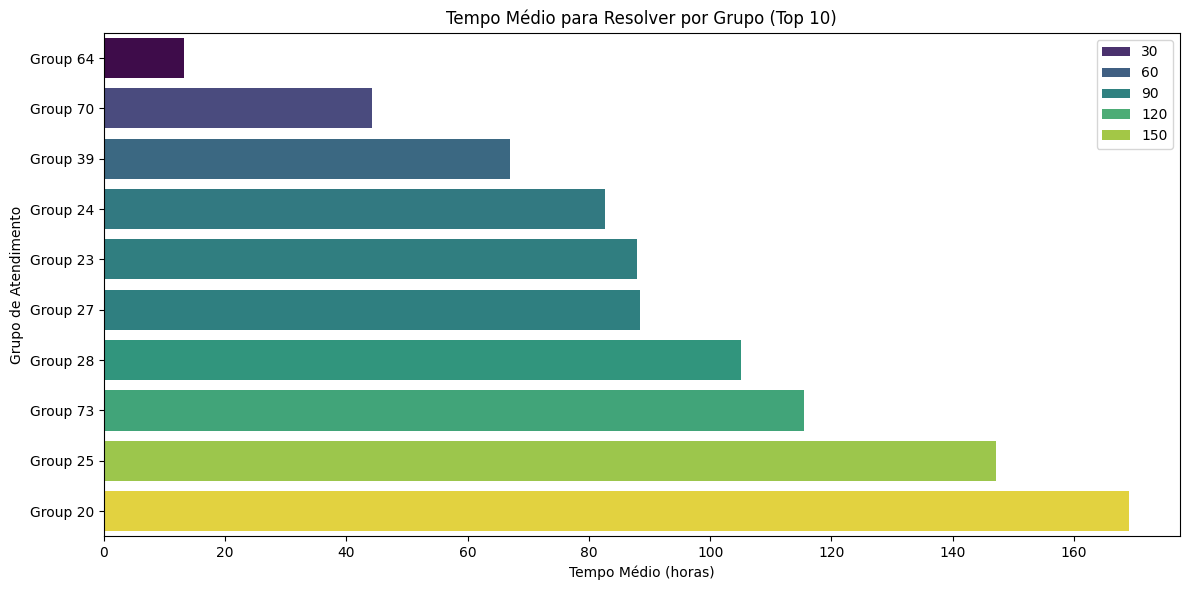

In [ ]:
# Tempo médio para resolver por grupo (Top 10)
top_grupos = df['assignment_group'].value_counts().head(10).index
grupo_tempo = df[df['assignment_group'].isin(top_grupos)].groupby('assignment_group')['tempo_para_resolver'].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=grupo_tempo.values, y=grupo_tempo.index, palette="viridis", hue=grupo_tempo.values)
plt.title('Tempo Médio para Resolver por Grupo (Top 10)')
plt.xlabel('Tempo Médio (horas)')
plt.ylabel('Grupo de Atendimento')
plt.tight_layout()
plt.show()

No gráfico acima podemos ver a média de tempo de resolução de tickets com relação ao grupo responsável por sua resolução.

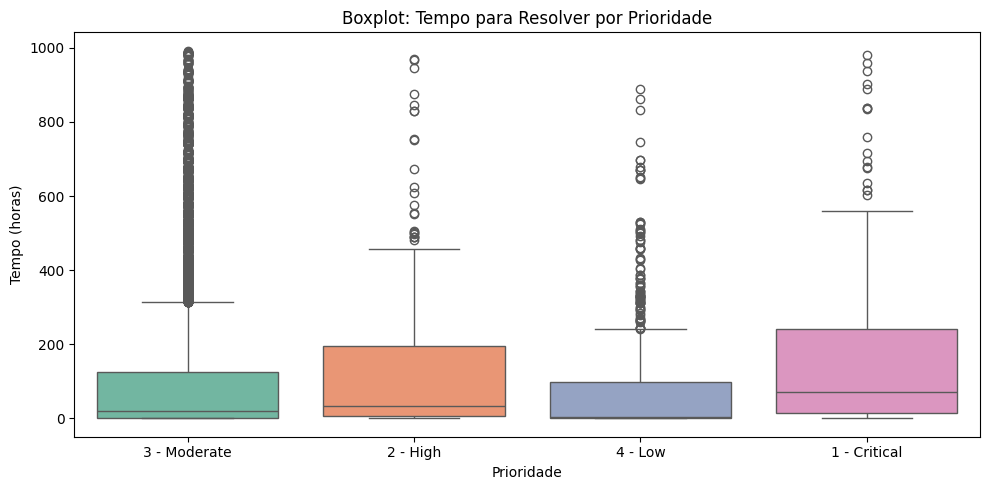

In [ ]:
# Tempo para Resolver por Prioridade
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[df['tempo_para_resolver'] < 1000], x='priority', y='tempo_para_resolver', palette="Set2")
plt.title("Boxplot: Tempo para Resolver por Prioridade")
plt.xlabel("Prioridade")
plt.ylabel("Tempo (horas)")
plt.tight_layout()
plt.show()

No gráfico boxplot acima podemos observar um grande número de outliers que acreditamos possam ser fundamentais para o entendimento de tantos tickets que não cumpriram o SLA.

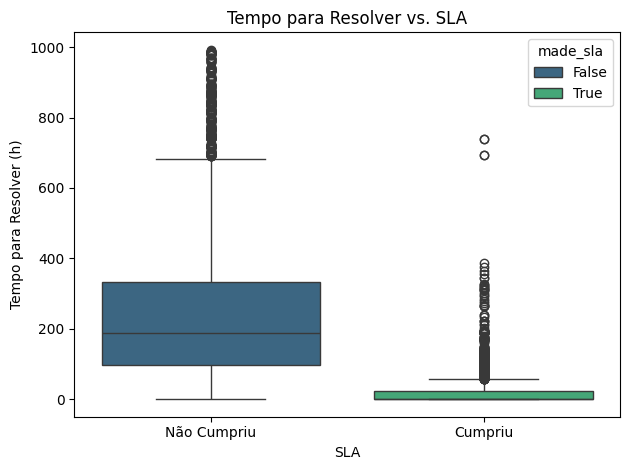

In [ ]:
# Tempo Médio por SLA
plt.figure()
sns.boxplot(data=df[df['tempo_para_resolver'] < 1000], x='made_sla', y='tempo_para_resolver', palette="viridis", hue='made_sla')
plt.title("Tempo para Resolver vs. SLA")
plt.xticks([0, 1], ['Não Cumpriu', 'Cumpriu'])
plt.xlabel("SLA")
plt.ylabel("Tempo para Resolver (h)")
plt.tight_layout()
plt.show()

No gráfico boxplot acima podemos observar um grande número de outliers que acreditamos possam ser fundamentais para o entendimento de tantos tickets que não cumpriram o SLA.

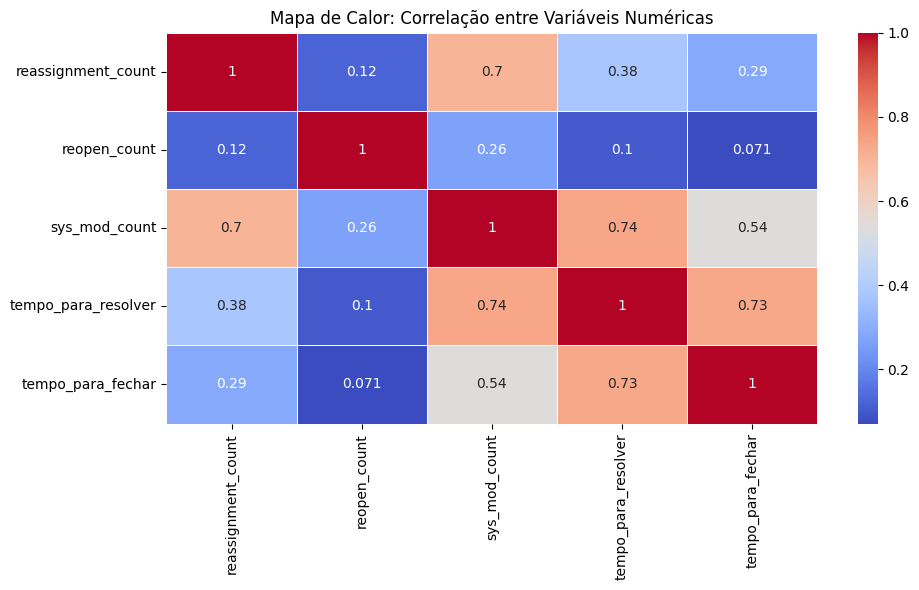

In [ ]:
# HEATMAP de Correlação
# Seleção de  colunas numéricas
df_numeric = df[['reassignment_count', 'reopen_count', 'sys_mod_count', 'tempo_para_resolver', 'tempo_para_fechar']].dropna()

# Cálculo correlação
correlation = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de Calor: Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

Conforme o esperado, mapa de calor da matriz de correlação 'tempo_para_resolver' e 'tempo_para_fechar'. Esse conclusão fica bastante evidente uma vez que tratamos de operações de SLA, que tem o tempo como critério de completude dos acordos por prioridade de cada ticket.

### Remoção de Colunas que não serão relevantes para a análise

In [ ]:
# Remoção de Colunas que não serão relevantes para a análise
columns_to_drop = ['active','caller_id','opened_by','sys_created_by','sys_created_at','sys_updated_by',
                   'sys_updated_at','contact_type','u_symptom','cmdb_ci','notify','problem_id','rfc',
                   'vendor','caused_by','incident_state','number']
df = df.drop(columns=columns_to_drop, axis = 1)

### Tratamento de Valores Nulos

Verificar se há campos nulos

In [ ]:
# Verificar a presença de valores nulos no dataset original
print("Valores nulos")
df.isnull().sum()

Valores nulos


,0
reassignment_count,0
reopen_count,0
sys_mod_count,0
made_sla,0
opened_at,0
location,0
category,1
subcategory,1
impact,0
urgency,0


Remover campos nulos

In [ ]:
# Remover linhas com qualquer valor NaN
df = df.dropna(subset=['category', 'subcategory','assignment_group','assigned_to','closed_code'])
df.isnull().sum()

,0
reassignment_count,0
reopen_count,0
sys_mod_count,0
made_sla,0
opened_at,0
location,0
category,0
subcategory,0
impact,0
urgency,0


#4 - Definição do target, variáveis e divisão dos dados

A Validação cruzada com **stratify**=y e **num_particoes** = 10 foi escolhida para se ter uma valor de partida e no futuro ter como comparação na tentativa com novos valores para tais parâmetros.

In [ ]:

# ===========================================================
# Devido a redução de dados, reduzi o dataset em 5000 linhas
#============================================================

# Definir as colunas de interesse (não numéricas)
colunas_texto = ['location', 'impact', 'urgency', 'priority']

# Inicializar o codificador de rótulos
le = LabelEncoder()

# Criar um DataFrame para armazenar os valores codificados
df_codificado = pd.DataFrame()

# Aplicar a codificação de rótulos a cada coluna de texto e adicionar ao novo DataFrame
for col in colunas_texto:
    df_codificado[f'{col}_codificado'] = le.fit_transform(df[col])

# Calcular a média das colunas codificadas para cada linha e adicionar ao DataFrame original
df['media_colunas_codificadas'] = df_codificado.mean(axis=1)

# Ordenar o DataFrame pela nova coluna de média, em ordem decrescente
df_ordenado = df.sort_values(by='media_colunas_codificadas', ascending=False)

# Selecionar as primeiras 5000 linhas
df_top_5000 = df_ordenado.head(5000)
df=df_top_5000

# ===========================================================
#============================================================


# Definir variável alvo (target)
target = "made_sla"

# Definir features (removendo colunas irrelevantes como datas e o próprio target)
#X = df.drop(columns=[target, "opened_at", "resolved_at", "closed_at"])
X = df.drop(columns=[target, "opened_at", "resolved_at", "closed_at", "tempo_para_resolver", "tempo_para_fechar", "reassignment_count","reopen_count","sys_mod_count","closed_code","resolved_by"])
y = df[target]



# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Formato treino:", X_train.shape, y_train.shape)
print("Formato teste:", X_test.shape, y_test.shape)



# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

Formato treino: (3500, 11) (3500,)
Formato teste: (1500, 11) (1500,)


# 5 - Tratamento de dados e **Pipeline** de pré-processamento

O código abaixo é uma forma de preparar os dados para a modelagem. Ele define uma pipeline de pré-processamento robusta que lida com valores ausentes e escala/codifica os dados.

In [ ]:
# Identificar colunas numéricas e categóricas
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols]

# Pipelines para pré-processamento de cada tipo de coluna
numeric_pipe = Pipeline(steps=[
    # Preenche valores ausentes em colunas numéricas com a mediana
    ("imputer", SimpleImputer(strategy="median")),
    # Escala os dados para que tenham média zero e variância unitária
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    # Preenche valores ausentes em colunas categóricas com o valor mais frequente
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # Converte colunas categóricas para formato binário (One-Hot Encoding)
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combinar as pipelines em um único pré-processador
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# Imprimir as colunas para verificação
print("num_cols:", num_cols[:5], "...")
print("cat_cols:", cat_cols[:5], "...")

num_cols: ['media_colunas_codificadas'] ...
cat_cols: ['location', 'category', 'subcategory', 'impact', 'urgency'] ...


# 6 - Baseline e modelos candidatos

Nesta etapa, vamos estabelecer um ponto de referência simples, enquanto a etapa de modelos candidatos é onde você introduz modelos mais complexos para tentar superar o baseline

Validação Cruzada (10-fold CV):

KNN: 0.7060 ± 0.0224
CART: 0.7089 ± 0.0155
NB: 0.6989 ± 0.0168
RandomForest: 0.7289 ± 0.0157
LogisticRegression: 0.7160 ± 0.0223


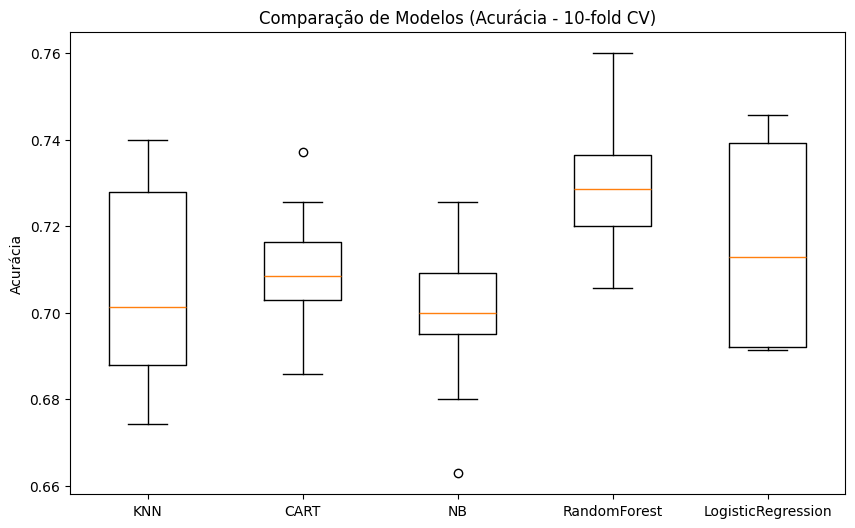

In [ ]:
# Modelagem

# Identificar colunas
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

# Pré-processamento padrão (para a maioria dos modelos)
standard_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ("cat", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols)
    ]
)

# Pré-processamento para MultinomialNB (sem valores negativos)
nb_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler()) # Usando MinMaxScaler
        ]), numeric_cols),
        ("cat", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols)
    ]
)

# Lista de modelos
models = [
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier(random_state=seed)),
    ("NB", MultinomialNB()),
    ("RandomForest", RandomForestClassifier(random_state=seed, n_estimators=100)),
    ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed))
]
results = []
names = []

# Avaliar modelos com cross-validation
print("Validação Cruzada (10-fold CV):\n")
for name, model in models:
    # Escolhe o pré-processador com base no modelo
    if name == "NB":
        preprocessor_to_use = nb_preprocessor
    else:
        preprocessor_to_use = standard_preprocessor

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor_to_use),
        ("classifier", model)
    ])

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    try:
        cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring="accuracy")
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean():.4f} ± {cv_results.std():.4f}")
    except Exception as e:
        print(f"Erro ao avaliar o modelo {name}: {e}")
        continue

# Boxplot de comparação (só se houver resultados)
if results:
    plt.figure(figsize=(10, 6))
    plt.boxplot(results, labels=names)
    plt.title("Comparação de Modelos (Acurácia - 10-fold CV)")
    plt.ylabel("Acurácia")
    plt.show()

## 6.1 - Treino e avaliação rápida (baseline vs candidatos)

Nesse treino rápido,  adotei poucos modelos somente para fazer uma análise breve, e assim dimiuindo o tempo de execução do notebook. Mais modelos serão avaliados na próxima etapa de avalição e pradronização dos modelos.


Avaliação Final no Conjunto de Teste:

Modelo: KNN
Acurácia no conjunto de teste: 0.7373

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.77      0.86      0.81      1002
        True       0.63      0.49      0.55       498

    accuracy                           0.74      1500
   macro avg       0.70      0.68      0.68      1500
weighted avg       0.73      0.74      0.73      1500

Matriz de Confusão:
 [[861 141]
 [253 245]]


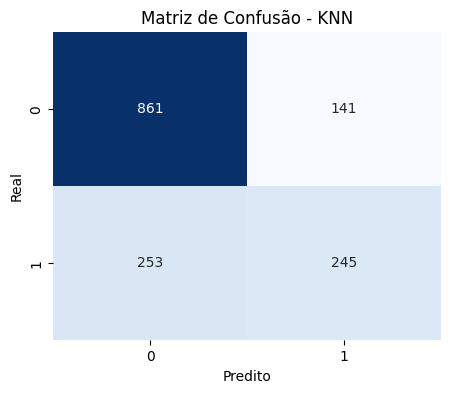

Modelo: CART
Acurácia no conjunto de teste: 0.7173

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.77      0.81      0.79      1002
        True       0.58      0.52      0.55       498

    accuracy                           0.72      1500
   macro avg       0.68      0.67      0.67      1500
weighted avg       0.71      0.72      0.71      1500

Matriz de Confusão:
 [[816 186]
 [238 260]]


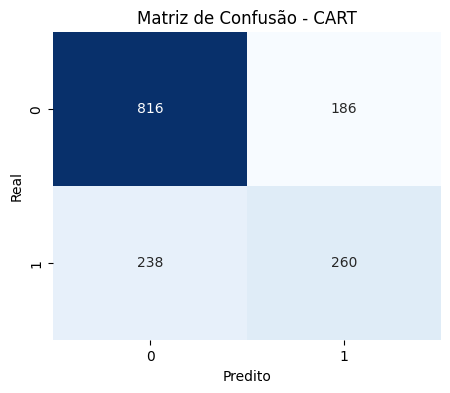

Modelo: NB
Acurácia no conjunto de teste: 0.7080

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.78      0.79      0.78      1002
        True       0.56      0.54      0.55       498

    accuracy                           0.71      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.71      0.71      0.71      1500

Matriz de Confusão:
 [[791 211]
 [227 271]]


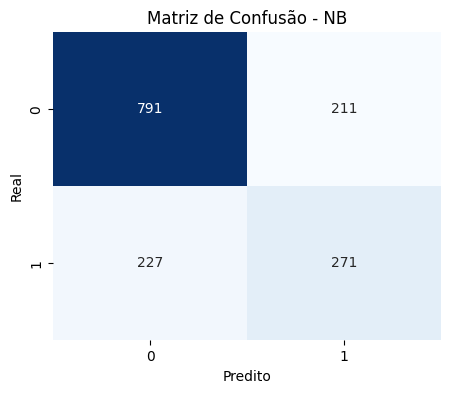

Modelo: RandomForest
Acurácia no conjunto de teste: 0.7427

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.78      0.86      0.82      1002
        True       0.64      0.51      0.57       498

    accuracy                           0.74      1500
   macro avg       0.71      0.68      0.69      1500
weighted avg       0.73      0.74      0.73      1500

Matriz de Confusão:
 [[861 141]
 [245 253]]


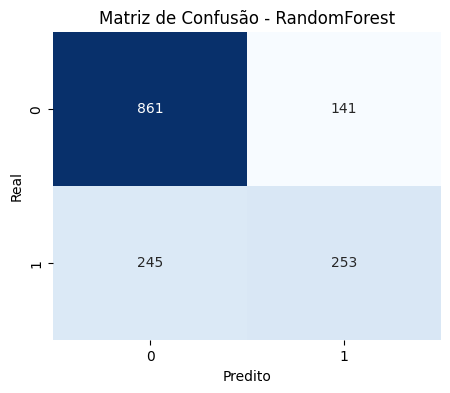

Modelo: LogisticRegression
Acurácia no conjunto de teste: 0.7387

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.77      0.88      0.82      1002
        True       0.65      0.46      0.54       498

    accuracy                           0.74      1500
   macro avg       0.71      0.67      0.68      1500
weighted avg       0.73      0.74      0.73      1500

Matriz de Confusão:
 [[877 125]
 [267 231]]


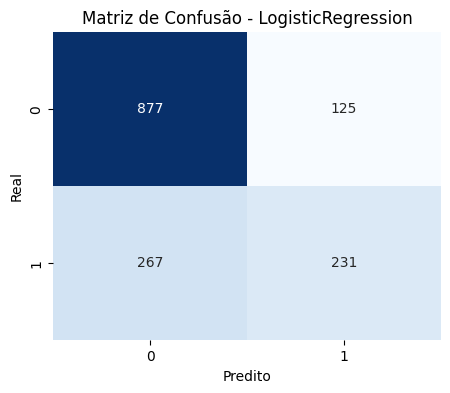

In [ ]:

# Avaliação final em TESTE

print("\nAvaliação Final no Conjunto de Teste:\n")
for name, model in models:
    # Escolhe o pré-processador com base no modelo
    if name == "NB":
        preprocessor_to_use = nb_preprocessor
    else:
        preprocessor_to_use = standard_preprocessor

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor_to_use),
        ("classifier", model)
    ])

    # Adiciona o tratamento de erro aqui
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print("="*60)
        print(f"Modelo: {name}")
        print(f"Acurácia no conjunto de teste: {acc:.4f}")
        print("\nRelatório de Classificação:")
        print(classification_report(y_test, y_pred))

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        print("Matriz de Confusão:\n", cm)

        # Heatmap da matriz de confusão
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Matriz de Confusão - {name}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.show()

    except Exception as e:
        print("="*60)
        print(f"Erro ao avaliar o modelo {name}: {e}")
        continue

## Criação e avaliação de modelos: dados padronizados e normalizados

Como estamos tratando de uma problema **supervisionado** e de **classificação**, sabemos através do camdo **MADE_SLA**, quais foram os ticket que atenderam ou não o SLA acordado. Send oassim,  usaremos essa clase para aferir a saida dos modelos.

Nessa segunda avaliação, acrestei mais modelos.

Validação Cruzada (10-fold CV):

LR-orig: 0.716 (0.023)
KNN-orig: 0.705 (0.021)
CART-orig: 0.709 (0.015)
NB-orig: 0.444 (0.019)
RF-orig: 0.729 (0.016)
ET-orig: 0.725 (0.021)
Ada-orig: 0.699 (0.011)
GB-orig: 0.722 (0.019)
VOT-orig: 0.737 (0.018)
LR-padr: 0.716 (0.022)
KNN-padr: 0.706 (0.022)
CART-padr: 0.709 (0.015)
NB-padr: 0.453 (0.022)
RF-padr: 0.729 (0.016)
ET-padr: 0.725 (0.021)
Ada-padr: 0.699 (0.011)
GB-padr: 0.722 (0.019)
VOT-padr: 0.736 (0.017)
LR-norm: 0.716 (0.024)
KNN-norm: 0.705 (0.021)
CART-norm: 0.709 (0.015)
NB-norm: 0.444 (0.019)
RF-norm: 0.729 (0.016)
ET-norm: 0.725 (0.021)
Ada-norm: 0.699 (0.011)
GB-norm: 0.722 (0.019)
VOT-norm: 0.737 (0.018)


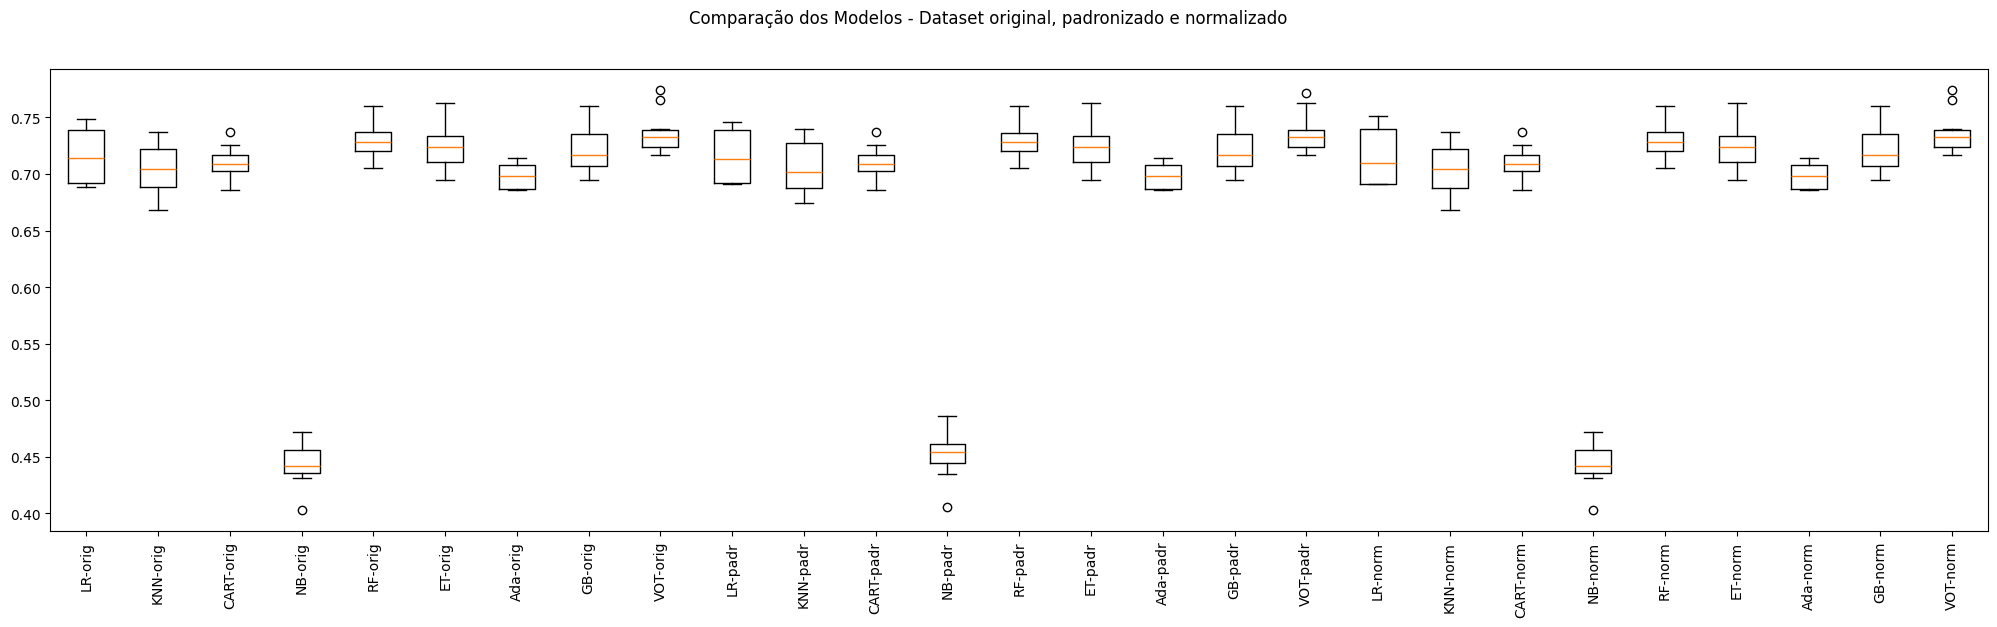

In [ ]:

# Target
target = "made_sla"

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

# Identificar colunas
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

# Pré-processamento com imputação e escalonamento
numeric_transformer_standard = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
numeric_transformer_minmax = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
numeric_transformer_pass = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('passthrough', 'passthrough')
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combinar as transformações
preprocessor_standard = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_standard, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)
preprocessor_minmax = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_minmax, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)
preprocessor_pass = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pass, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Definições dos modelos
num_trees = 100
max_features = "sqrt"

# Re-inicialize os modelos para cada pipeline para evitar o uso de modelos já treinados
def get_models():
    # Definição dos modelos base para o VotingClassifier
    voting_estimators = [
        ('LR', LogisticRegression(max_iter=200, random_state=seed)),
        ('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)),
        ('GB', GradientBoostingClassifier(n_estimators=num_trees, random_state=seed))
    ]
    voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

    return [
        ("LR", LogisticRegression(max_iter=200, random_state=seed)),
        ("KNN", KNeighborsClassifier()),
        ("CART", DecisionTreeClassifier(random_state=seed)),
        ("NB", GaussianNB()),
        ("RF", RandomForestClassifier(n_estimators=num_trees, max_features=max_features, random_state=seed)),
        ("ET", ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features, random_state=seed)),
        ("Ada", AdaBoostClassifier(n_estimators=num_trees, random_state=seed)),
        ("GB", GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)),
        ("VOT", voting_clf)
    ]

# Montar pipelines
pipelines = []

# Original (agora com imputação)
for name, model in get_models():
    pipelines.append((f"{name}-orig", Pipeline([("preprocessor", preprocessor_pass), ("clf", model)])))

# Padronizado
for name, model in get_models():
    pipelines.append((f"{name}-padr", Pipeline([("preprocessor", preprocessor_standard), ("clf", model)])))

# Normalizado
for name, model in get_models():
    pipelines.append((f"{name}-norm", Pipeline([("preprocessor", preprocessor_minmax), ("clf", model)])))

# Executar pipelines com CV
results = []
names = []
scoring = "accuracy"
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

print("Validação Cruzada (10-fold CV):\n")
for name, pipeline in pipelines:
    try:
        cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = f"{name}: {cv_results.mean():.3f} ({cv_results.std():.3f})"
        print(msg)
    except Exception as e:
        print(f"Erro ao avaliar a pipeline {name}: {e}")

# Boxplot comparativo
fig = plt.figure(figsize=(25,6))
fig.suptitle("Comparação dos Modelos - Dataset original, padronizado e normalizado")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()



# 7 - Validação e Otimização de Hiperparâmetros

Considerando o gráfico de Boxplot acima,  escolhi o **VotingClassifier** para a otimização de hiperparâmetros.

Apesar de **GridSearchCV** testar todas as combinações possíveis do grid  e por isso ser mais completo, ele pode ser muito lento.

Sendo assim, eu preferi utilizar o **RandomizedSearchCV** que testa um número fixo de combinações aleatórias (n_iter). Ele é muito mais rápido, quando o espaço de busca é grande.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


# VotingClassifier com RandomizedSearchCV


# Voting base
voting_clf = VotingClassifier(
    estimators=[
        ("LR", LogisticRegression(max_iter=200, random_state=seed)),
        ("RF", RandomForestClassifier(random_state=seed)),
        ("GB", GradientBoostingClassifier(random_state=seed))
    ],
    voting="soft"
)

# Pipeline para incluir o preprocessor robusto
pipeline_voting = Pipeline([
    ("preprocessor", preprocessor_standard), # Usando o preprocessor corrigido
    ("clf", voting_clf)
])

# Distribuições de hiperparâmetros
param_dist = {
    "clf__LR__C": uniform(0.01, 10),
    "clf__RF__n_estimators": randint(50, 300),
    "clf__RF__max_depth": [None, 5, 10, 20],
    "clf__GB__n_estimators": randint(50, 300),
    "clf__GB__learning_rate": uniform(0.01, 0.3)
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_voting,
    param_distributions=param_dist,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="accuracy",
    random_state=seed,
    n_jobs=-1,
    verbose=2,
    error_score='raise' # Adicionando esta linha para uma depuração mais detalhada, se necessário
)

print("Rodando RandomizedSearchCV para VotingClassifier...\n")
random_search.fit(X_train, y_train)

# 11. Resultados
print("Melhores parâmetros encontrados (RandomizedSearch):")
print(random_search.best_params_)
print(f"\nMelhor acurácia média em CV: {random_search.best_score_:.4f}")


Rodando RandomizedSearchCV para VotingClassifier...

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros encontrados (RandomizedSearch):
{'clf__GB__learning_rate': np.float64(0.150028867974394), 'clf__GB__n_estimators': 278, 'clf__LR__C': np.float64(6.085448519014383), 'clf__RF__max_depth': None, 'clf__RF__n_estimators': 122}

Melhor acurácia média em CV: 0.7346


#8 - Avaliação final, análise de erros e limitações

 O modelo tem uma boa acurácia geral de 73,53%, mas o recall de 81,28% é o ponto forte. Isso significa que o modelo é muito bom em identificar os casos em que o SLA foi realmente feito. No entanto, a precisão de 64,67% indica que ele ainda comete muitos erros ao classificar casos em que o SLA não foi feito, mas ele prevê que foi. Ou seja, ele tende a ser mais otimista do que deveria.


Acurácia no conjunto de teste: 0.7487

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.90      0.83      1002
        True       0.69      0.45      0.54       498

    accuracy                           0.75      1500
   macro avg       0.73      0.67      0.68      1500
weighted avg       0.74      0.75      0.73      1500



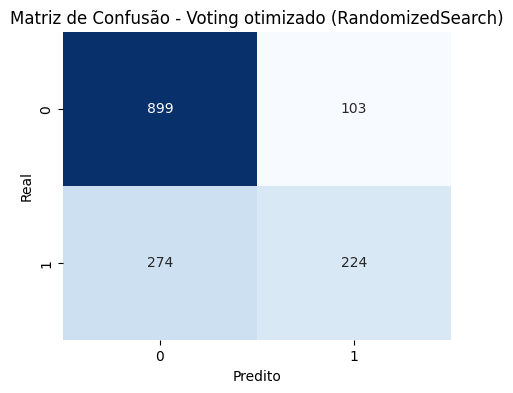

In [ ]:
# Avaliar no conjunto de teste
best_model_random = random_search.best_estimator_
y_pred = best_model_random.predict(X_test)

print(f"\nAcurácia no conjunto de teste: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusão - Voting otimizado (RandomizedSearch)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# 9 - Engenharia de atributos (detalhe)

# 11 - Boas práticas e rastreabilidade

#12 -0 Conclusões e próximos passos